In [63]:
import numpy as np
import torch 
torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
from tqdm import tqdm,trange    
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

import os

print(os.getcwd())  

from flow_model_manipulator import Flow
import open3d as o3d

weights_dir = "../flow_training_weights"
opts_dir = "../flow_training_opts"
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(opts_dir, exist_ok=True)



/home/alinjar/manipulator/manipulator_mujoco/flow_matching


In [64]:


torch.set_float32_matmul_precision('high')

# writer = SummaryWriter("./logs")
test = 'manipulator'

In [65]:
BATCH_SIZE      = 500
LEARNING_RATE   = 1e-2
SEED            = 0
DEVICE          = 'cuda'      
NUM_EPOCH       = 2000

In [66]:
torch.manual_seed(seed=SEED)
torch.cuda.manual_seed(seed=SEED)

In [67]:
class TrajDataset(Dataset):
    def __init__(self, theta_init_data, thetadot_init_data, target_pos_data, target_quat_data, index_data):
        
        # goal
        self.theta_init = theta_init_data
        self.thetadot_init = thetadot_init_data
        self.target_pos = target_pos_data
        self.target_quat = target_quat_data


        self.index = index_data
        
    
    def __len__(self):
        return len(self.theta_init)    
            
    def __getitem__(self, idx):

        theta_init = self.theta_init[idx]
        thetadot_init = self.thetadot_init[idx]
        target_pos = self.target_pos[idx]
        target_quat = self.target_quat[idx]
        index = self.index[idx]
                 
        return torch.tensor(theta_init).float(), torch.tensor(thetadot_init).float(), torch.tensor(target_pos).float(), \
            torch.tensor(target_quat).float(), index

In [68]:


# One step behind the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_dir)


/home/alinjar/manipulator/manipulator_mujoco


In [69]:


# Build relative paths from parent directory
data_dir = os.path.join(parent_dir, "custom_data_['target_2']_inference_False")
pcd_dir = os.path.join(parent_dir, "pcd_data")

print(data_dir)


/home/alinjar/manipulator/manipulator_mujoco/custom_data_['target_2']_inference_False


In [70]:
# Load the data

theta_init_data = np.loadtxt(os.path.join(data_dir, "theta.csv"), delimiter=",")
thetadot_init_data = np.loadtxt(os.path.join(data_dir, "thetadot.csv"), delimiter=",")
target_pos_data = np.loadtxt(os.path.join(data_dir, "target_positions.csv"), delimiter=",")
target_quat_data = np.loadtxt(os.path.join(data_dir, "target_quaternions.csv"), delimiter=",")
index_data = np.loadtxt(os.path.join(data_dir, "index.csv"), delimiter=",")



pcd_path = os.path.join(pcd_dir, "output_scene_without_robot_unpacked_rgb.pcd")
pcd = o3d.io.read_point_cloud(pcd_path)

# points = np.asarray(pcd.points)       # XYZ points
# colors = np.asarray(pcd.colors)       # RGB (if present)

# Convert Open3D point cloud to a NumPy array
pcd_np = np.asarray(pcd.points)

# Then convert to PyTorch tensor (and move to the correct device)

pcd_tensor = torch.tensor(pcd_np.T, dtype=torch.float32, device=DEVICE).unsqueeze(0)  # shape: [1, 3, length(pcd)]
pcd_tensor = pcd_tensor.permute(2, 1, 0)  # shape: [length(pcd), 3, 1]



print(pcd_tensor.shape)
# print(colors.shape)

print(theta_init_data.shape)
print(thetadot_init_data.shape)
print(target_pos_data.shape)
print(target_quat_data.shape)


torch.Size([307200, 3, 1])
(106, 6)
(106, 6)
(106, 3)
(106, 4)


In [71]:
theta_init_mean, theta_init_std = torch.tensor(theta_init_data.mean()).to(DEVICE), torch.tensor(theta_init_data.std()).to(DEVICE)
thetadot_init_mean, thetadot_init_std = torch.tensor(thetadot_init_data.mean()).to(DEVICE), torch.tensor(thetadot_init_data.std()).to(DEVICE)
target_pos_mean, target_pos_std = torch.tensor(target_pos_data.mean()).to(DEVICE), torch.tensor(target_pos_data.std()).to(DEVICE)
target_quat_mean, target_quat_std = torch.tensor(target_quat_data.mean()).to(DEVICE), torch.tensor(target_quat_data.std()).to(DEVICE)


In [72]:
dataset = TrajDataset(theta_init_data, thetadot_init_data, target_pos_data, target_quat_data, index_data)
print("len(dataset)", len(dataset))

train_size = int(0.9 * len(dataset))  
test_size = len(dataset) - train_size  

# Create a generator with a fixed seed
generator = torch.Generator().manual_seed(0)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

out_chan = 512

flow = Flow(out_chan,theta_init_mean,theta_init_std, thetadot_init_mean, theta_init_std, target_pos_mean, target_pos_std,
            target_quat_mean, target_quat_std).cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE)

len(dataset) 106


In [73]:
flow.train()
c_flow = torch.compile(flow)


In [74]:

avg_losses = []
last_loss = torch.inf

NUM_EPOCH = 100
for epoch in range(NUM_EPOCH):
	losses = []
	
	for (theta_init,thetadot_init, target_pos, target_quat, index) in tqdm(train_loader):


		theta_init = theta_init.to(DEVICE)
		thetadot_init = thetadot_init.to(DEVICE)
		target_pos = target_pos.to(DEVICE)
		target_quat = target_quat.to(DEVICE)


		motion_data = torch.cat([theta_init, thetadot_init, target_pos, target_quat], dim=-1)  # or dim=1
		x_1 = motion_data

		x_0 = torch.randn_like(x_1)
		t = torch.rand(len(x_1), 1, 1).to(device=DEVICE)
		x_t = (1 - t) * x_0 + t * x_1
		dx_t = x_1 - x_0
	
		loss = loss_fn(c_flow(x_t, motion_data, t, pcd_tensor), dx_t)
		losses.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()


	mean_loss = np.mean(losses)
	avg_losses.append(mean_loss)
	# scheduler.step()

	if epoch % 5 == 0:
		print(f"Epoch: {epoch + 1}, Train Loss: {mean_loss:.3f}")
	#writer.add_scalar('test_{}'.format(test), loss, epoch)

	if loss <= last_loss:
		# torch.save(flow.state_dict(), f"./weights/test_{test}_lowest.pt")
		# torch.save(optimizer.state_dict(), f"./opts/test_{test}_lowest.pt")
		torch.save(flow.state_dict(), f"{weights_dir}/test_{test}.pt")
		torch.save(optimizer.state_dict(), f"{opts_dir}/test_{test}.pt")
		last_loss = loss

100%|██████████| 1/1 [00:00<00:00, 33.45it/s]

Epoch: 1, Train Loss: 2.124



100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


Epoch: 6, Train Loss: 3.830


100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


Epoch: 11, Train Loss: 2.515


100%|██████████| 1/1 [00:00<00:00, 31.37it/s]


Epoch: 16, Train Loss: 2.595


100%|██████████| 1/1 [00:00<00:00, 33.50it/s]


Epoch: 21, Train Loss: 1.926


100%|██████████| 1/1 [00:00<00:00, 31.81it/s]


Epoch: 26, Train Loss: 1.603


100%|██████████| 1/1 [00:00<00:00, 34.61it/s]


Epoch: 31, Train Loss: 1.457


100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


Epoch: 36, Train Loss: 1.273


100%|██████████| 1/1 [00:00<00:00, 30.71it/s]


Epoch: 41, Train Loss: 1.268


100%|██████████| 1/1 [00:00<00:00, 36.05it/s]


Epoch: 46, Train Loss: 1.152


100%|██████████| 1/1 [00:00<00:00, 32.74it/s]


Epoch: 51, Train Loss: 1.161


100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Epoch: 56, Train Loss: 1.225


100%|██████████| 1/1 [00:00<00:00, 31.17it/s]


Epoch: 61, Train Loss: 1.110


100%|██████████| 1/1 [00:00<00:00, 31.00it/s]


Epoch: 66, Train Loss: 1.098


100%|██████████| 1/1 [00:00<00:00, 32.33it/s]


Epoch: 71, Train Loss: 1.122


100%|██████████| 1/1 [00:00<00:00, 31.80it/s]


Epoch: 76, Train Loss: 1.038


100%|██████████| 1/1 [00:00<00:00, 33.70it/s]


Epoch: 81, Train Loss: 1.085


100%|██████████| 1/1 [00:00<00:00, 32.42it/s]


Epoch: 86, Train Loss: 1.083


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


Epoch: 91, Train Loss: 1.105


100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


Epoch: 96, Train Loss: 1.027


100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


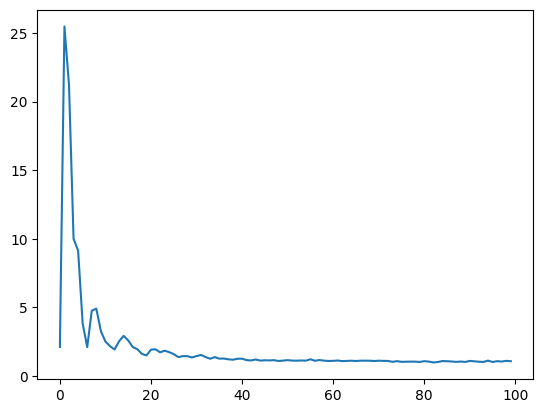

In [75]:
%matplotlib inline
plt.Figure()
plt.plot(avg_losses)
plt.show()